In [4]:
import sys

MODULES_PATH = "../modules"
if MODULES_PATH not in sys.path:
    sys.path.append(MODULES_PATH)

from assets_etl import *
from tweets_etl import *
from bsts import *

import pandas as pd
import datetime as dt

import pickle

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SETUP

#### DOWNLOAD THE DATA NECESSARY FOR THE ANALYSIS

In [5]:
ticker2permno = {
    "tsla": 93436,
    "twtr": 14295, 
}

LOWERBOUND_DATE = "2010-01-01"
UPPERBOUND_DATE = "2022-12-31"

# wrds_loader = WRDSLoader(username="farouk_b")
# wrds_loader.download_stock_data(ticker2permno, from_=LOWERBOUND_DATE, to=UPPERBOUND_DATE, save_to="../data/stocks/", close_conn=True);

####  LOAD THE PARTITIONS OF TWEETS FOR THIS STUDY

In [6]:
ticker2partition = {
    "tsla": "TESLA",
    "twtr": "TWITTER",
    "btc": "CRYPTO",
    "doge": "CRYPTO",
    "eth": "CRYPTO"
}

tweets_dict = pickle.load(open("../data/tweets/parsed_tweets.pickle", 'rb'), encoding="utf-8")
selected_tweets_dict = process_tweets_dict(tweets_dict, most_popular=30)

#### LOAD AND PREPROCESS THE ASSET RETURNS

In [7]:
assets = {}
assets["tsla"] = bsts_prepare_stock(pd.read_csv("../data/stocks/tsla_2010_2022.csv"))
assets["twtr"] = bsts_prepare_stock(pd.read_csv("../data/stocks/twtr_2013_2022.csv"))
assets["btc"]  = bsts_prepare_crypto(pd.read_csv("../data/crypto/btc_2015_202304.csv"))
assets["doge"] = bsts_prepare_crypto(pd.read_csv("../data/crypto/doge_2017_202305.csv"))
assets["eth"]  = bsts_prepare_crypto(pd.read_csv("../data/crypto/eth_2017_202305.csv"))

ff6_df = bsts_prepare_f6(pd.read_csv("../data/factors/6-factors.csv"))

### BAYESIAN STRUCTURAL TIME-SERIES ANALYSIS OF CAUSAL IMPACT

In [8]:
tweet_texts = extract_tweets_dict_texts(selected_tweets_dict)

#### Tesla

In [73]:
tsla_tweet_ids = [
    # positive
    "1473814525774336006", 
    "1500330068228280321",
    "1197986509950861312",
    "1620498352214532096",
    "1526958110023245829",
    
    # negative
    "1462650961105670148",
    "996132429772410882",
    "996131586469842945",
    "1052356093534302208",
    "1616134378064859136",
    
    # neutral
    "1245009716935188481",
    "1354618504532684802",
    "1578170980283076608",
    "1259945593805221891",
    "1374617643446063105",
    "1120831425169674240"
]

for tweet_id in tsla_tweet_ids:
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")

[ID:1473814525774336006] Lots of Tesla cars to deliver before year end! Your support in taking delivery is much appreciated. 

Thanks also to the Tesla team working hard during the holidays!
[ID:1500330068228280321] Even some of the best AI software engineers in the world don’t realize how advanced Tesla AI has become
[ID:1197986509950861312] Better truck than an F-150, faster than a Porsche 911. Order Cybertruck online at https://t.co/hltT8dg2NO
[ID:1620498352214532096] What the Tesla Giga Nevada factory will look like when finished. https://t.co/0O5U8jRerQ
[ID:1526958110023245829] Exxon is rated top ten best in world for environment, social &amp; governance (ESG) by S&amp;P 500, while Tesla didn’t make the list!

ESG is a scam. It has been weaponized by phony social justice warriors.
[ID:1462650961105670148] Model S Plaid is sickkkk!!!!
[ID:996132429772410882] What’s actually amazing about this accident is that a Model S hit a fire truck at 60mph and the driver only broke an ankle. A

In [74]:
models = {}
for tweet_id in tsla_tweet_ids:
    tweet = extract_tweet(selected_tweets_dict, tweet_id)
    excess_rets = bsts_prepare_data(assets["tsla"], ff6_df)
    model = asset_tweet_pair_analysis(excess_rets, tweet)
    if model is not None:
        models[tweet_id] = model
    else:
        print(f"No data available around tweet date {tweet.date.values[0]} for tweet ID={tweet_id}")
    
print("\n##################################################################")
for tweet_id, model in models.items():
    print(f"TWEET ID: {tweet_id}")
    model.summary()
    print("\n##################################################################")

No data available around tweet date 2023-01-31T00:00:00.000000000 for tweet ID=1620498352214532096
No data available around tweet date 2023-01-19T00:00:00.000000000 for tweet ID=1616134378064859136

##################################################################
TWEET ID: 1473814525774336006
                                Average       Cumulative
Actual                                0                0
Predicted                             0                0
95% CI                           [0, 0]           [0, 0]
                                                        
Absolute Effect                       0                0
95% CI                           [0, 0]           [0, 0]
                                                        
Relative Effect                   19.3%            19.3%
95% CI                  [74.4%, -35.9%]  [74.4%, -35.9%]
                                                        
P-value                            0.0%                 
Prob. of Causal Effe

[ID:1473814525774336006] Lots of Tesla cars to deliver before year end! Your support in taking delivery is much appreciated. 

Thanks also to the Tesla team working hard during the holidays!
causality: 100%


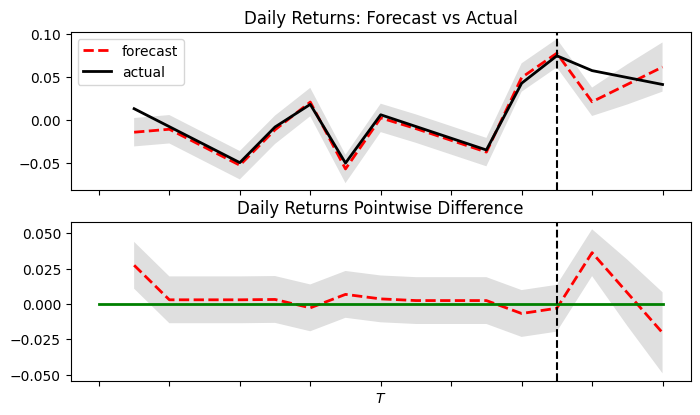

[ID:1500330068228280321] Even some of the best AI software engineers in the world don’t realize how advanced Tesla AI has become
causality: 12.5%


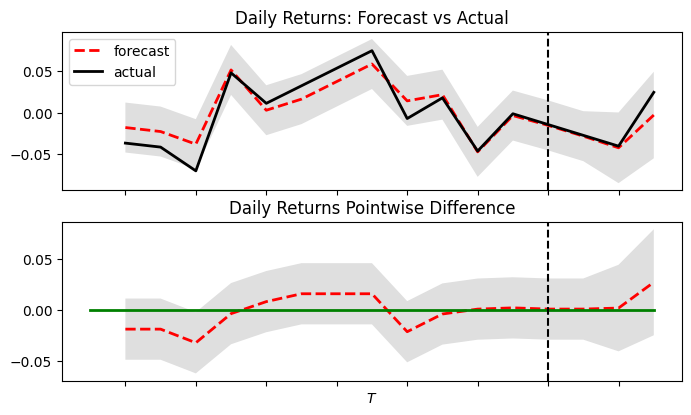

[ID:1197986509950861312] Better truck than an F-150, faster than a Porsche 911. Order Cybertruck online at https://t.co/hltT8dg2NO
causality: 0%


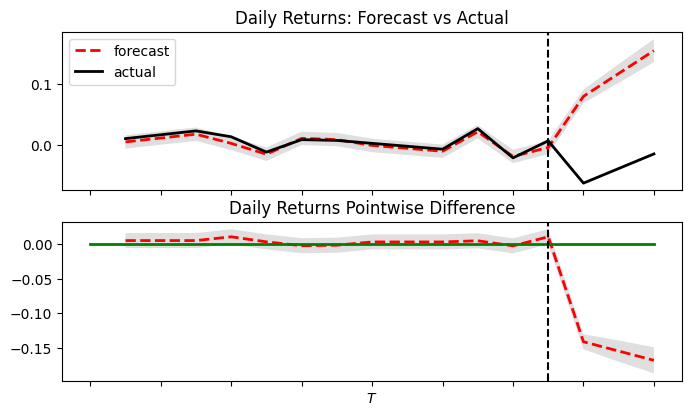

[ID:1526958110023245829] Exxon is rated top ten best in world for environment, social &amp; governance (ESG) by S&amp;P 500, while Tesla didn’t make the list!

ESG is a scam. It has been weaponized by phony social justice warriors.
causality: 96.8%


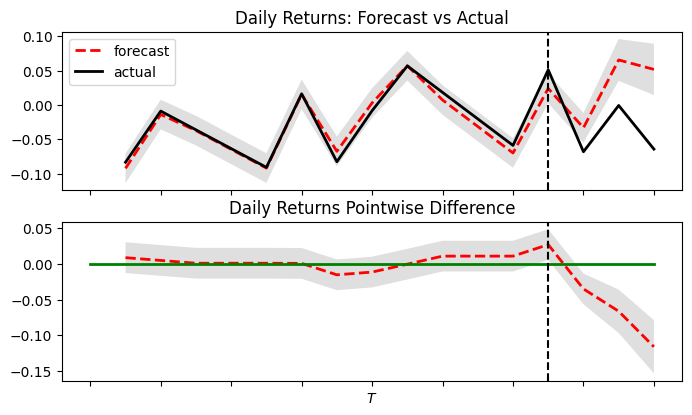

[ID:996132429772410882] What’s actually amazing about this accident is that a Model S hit a fire truck at 60mph and the driver only broke an ankle. An impact at that speed usually results in severe injury or death.
causality: 0%


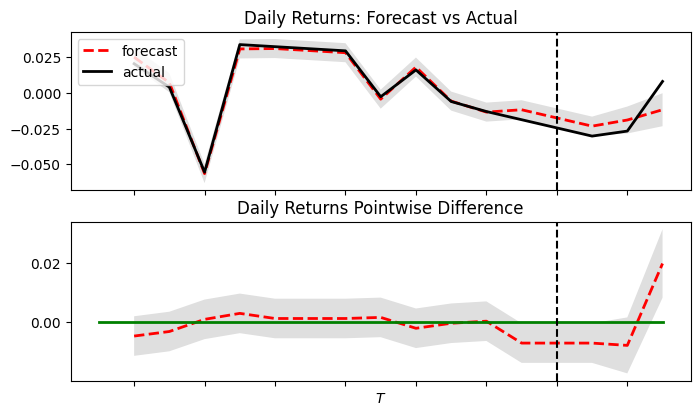

[ID:996131586469842945] It’s super messed up that a Tesla crash resulting in a broken ankle is front page news and the ~40,000 people who died in US auto accidents alone in past year get almost no coverage https://t.co/6gD8MzD6VU
causality: 0%


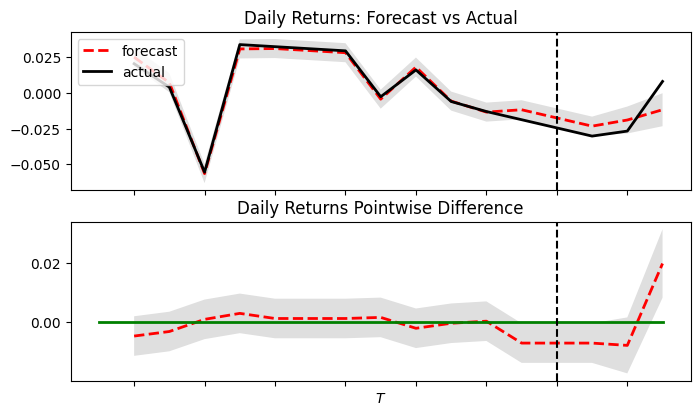

[ID:1052356093534302208] Just reviewed Tesla’s service locations in North America &amp; realized we have major gaps in geographic coverage! Sorry for this foolish oversight. Tesla will aim to cover all regions of NA (not just big cities) within 3 to 6 months.
causality: 100%


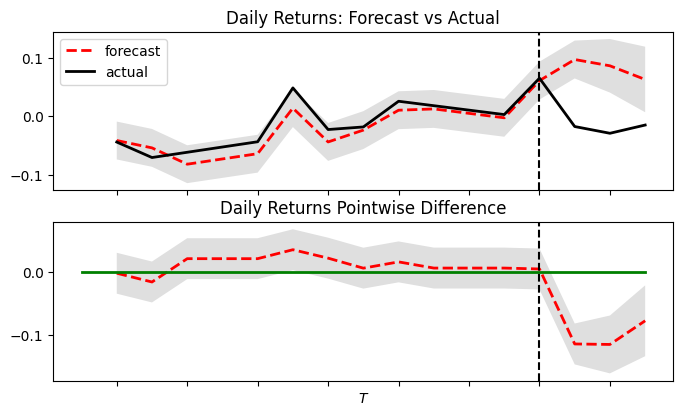

[ID:1245009716935188481] We have extra FDA-approved ventilators. Will ship to hospitals worldwide within Tesla delivery regions. Device &amp; shipping cost are free. Only requirement is that the vents are needed immediately for patients, not stored in a warehouse. Please me or @Tesla know.
causality: 98.2%


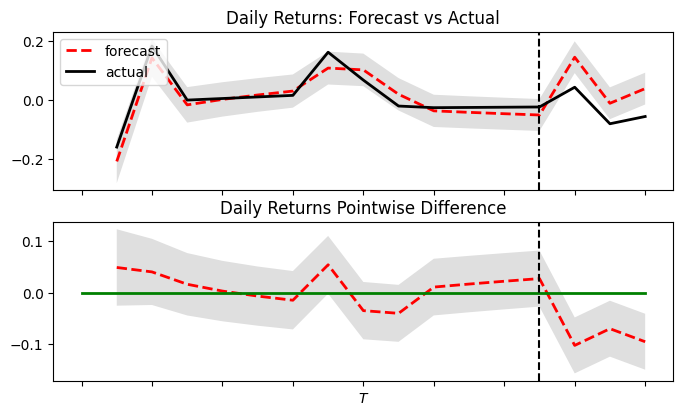

[ID:1354618504532684802] Plaid Model S ships next month https://t.co/HFUPTnQiPB
causality: 100%


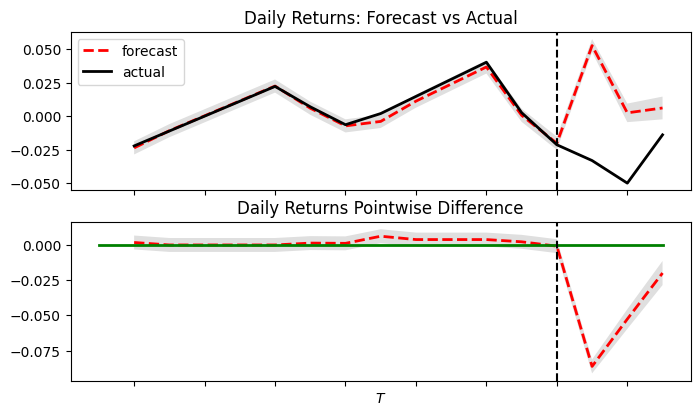

[ID:1578170980283076608] Excited to announce start of production of Tesla Semi Truck with deliveries to @Pepsi on Dec 1st! https://t.co/gq0l73iGRW
causality: 0%


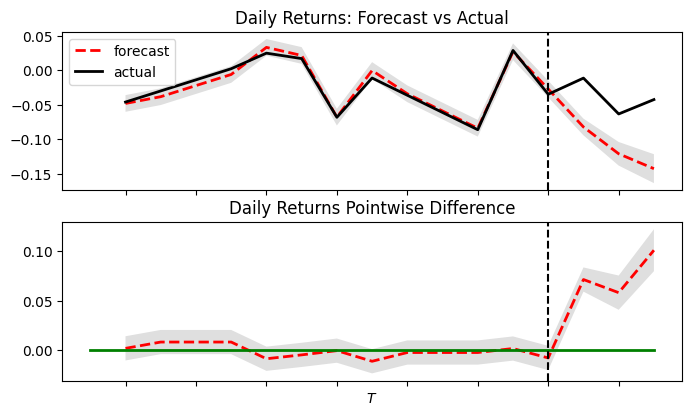

[ID:1374617643446063105] You can now buy a Tesla with Bitcoin
causality: 0%


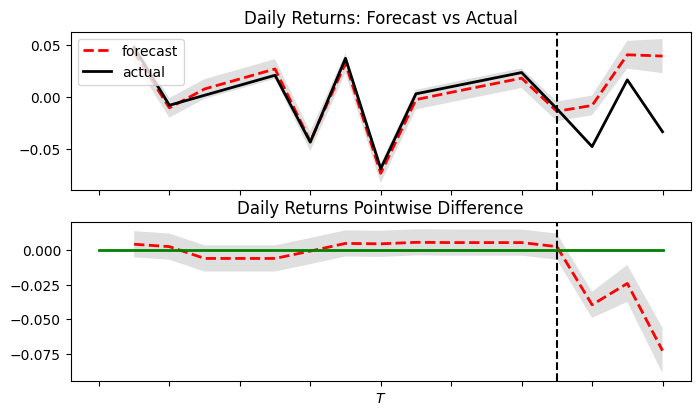

[ID:1120831425169674240] Tesla is going to develop a quiet, electric leafblower
causality: 1.2%


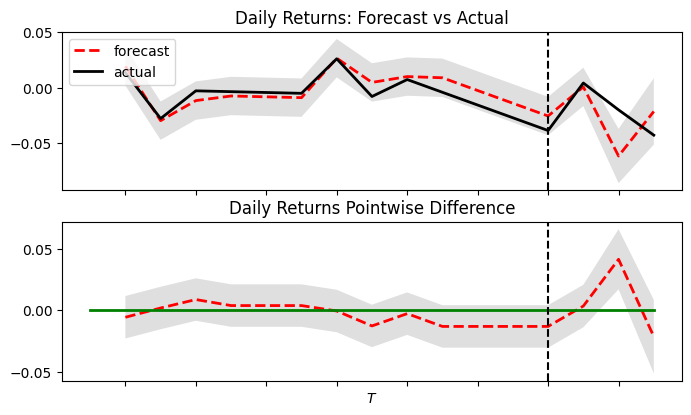

In [75]:
# !rm -r ../plots/bsts/tsla_*

tsla_plot_tweet_ids_causality = {
    "1473814525774336006": 1,
    "1500330068228280321": 0.125,
    "1197986509950861312": 0,
    "1526958110023245829": 0.968,
    "996132429772410882": 0,
    "996131586469842945": 0,
    "1052356093534302208": 1,
    "1245009716935188481": 0.982,
    "1354618504532684802": 1,
    "1578170980283076608": 0,
    "1374617643446063105": 0,
    "1120831425169674240": 0.012
}

for tweet_id, causality in tsla_plot_tweet_ids_causality.items():
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")
    print(f"causality: {causality  * 100}%")
    models[tweet_id].plot(fname=f"../plots/bsts/tsla_{tweet_id}.png")

#### Twitter

In [76]:
twtr_tweet_ids = [
    # positive
    "1647339015132299264",
    "1520022726035058689",
    "1596621001693200385",
    "1515403974802870279",
    "1637235385070678017",
    "1608324539779551232",
    "1595505413113323520",
    
    # negative
    "1286697906536361987",
    "1595630109116989440",
    "1597032623020249088",
    "1595473875847942146",
    
    # neutral
    "1586059953311137792",
    "1608175680407191552",
    "1597300125243944961",
    "1588538640401018880"
]

for tweet_id in twtr_tweet_ids:
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")

[ID:1647339015132299264] Creators in Japan, Canada, Australia and New Zealand can now enable subscriptions on this platform. 

Our goal is to maximize the prosperity of creators!
[ID:1520022726035058689] @WholeMarsBlog The people of Twitter strongly agree that Twitter needs to be fixed
[ID:1596621001693200385] Follow World Cup on Twitter for best real-time coverage! https://t.co/9IfFSHbjl3
[ID:1515403974802870279] @ChrisJBakke Wow, with Jack departing, the Twitter board collectively owns almost no shares! Objectively, their economic interests are simply not aligned with shareholders.
[ID:1637235385070678017] This platform is growing fast! 

Just exceeded 8 billion user-minutes per day … of the most influential, smartest people on Earth 😉
[ID:1608324539779551232] Significant backend server architecture changes rolled out. Twitter should feel faster.
[ID:1595505413113323520] World Cup traffic hit almost 20,000 tweets per second today! Great work by Twitter team managing record usage.
[ID

In [77]:
models = {}
for tweet_id in twtr_tweet_ids: 
    tweet = extract_tweet(selected_tweets_dict, tweet_id)
    excess_rets = bsts_prepare_data(assets["twtr"], ff6_df)
    model = asset_tweet_pair_analysis(excess_rets, tweet)
    if model is not None:
        models[tweet_id] = model
    else:
        print(f"No data available around tweet date {tweet.date.values[0]} for tweet ID={tweet_id}")
    
print("\n##################################################################")
for tweet_id, model in models.items():
    print(f"TWEET ID: {tweet_id}")
    model.summary()
    print("\n##################################################################")

No data available around tweet date 2023-04-15T00:00:00.000000000 for tweet ID=1647339015132299264
No data available around tweet date 2022-11-26T00:00:00.000000000 for tweet ID=1596621001693200385
No data available around tweet date 2023-03-18T00:00:00.000000000 for tweet ID=1637235385070678017
No data available around tweet date 2022-12-29T00:00:00.000000000 for tweet ID=1608324539779551232
No data available around tweet date 2022-11-23T00:00:00.000000000 for tweet ID=1595505413113323520
No data available around tweet date 2022-11-24T00:00:00.000000000 for tweet ID=1595630109116989440
No data available around tweet date 2022-11-28T00:00:00.000000000 for tweet ID=1597032623020249088
No data available around tweet date 2022-11-23T00:00:00.000000000 for tweet ID=1595473875847942146
No data available around tweet date 2022-10-28T00:00:00.000000000 for tweet ID=1586059953311137792
No data available around tweet date 2022-12-28T00:00:00.000000000 for tweet ID=1608175680407191552
No data av

[ID:1515403974802870279] @ChrisJBakke Wow, with Jack departing, the Twitter board collectively owns almost no shares! Objectively, their economic interests are simply not aligned with shareholders.
causality: 4.0%


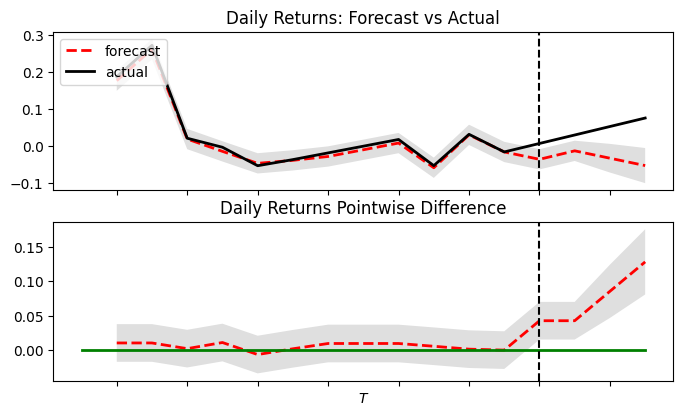

[ID:1286697906536361987] 🌹 Twitter sucks
causality: 98.9%


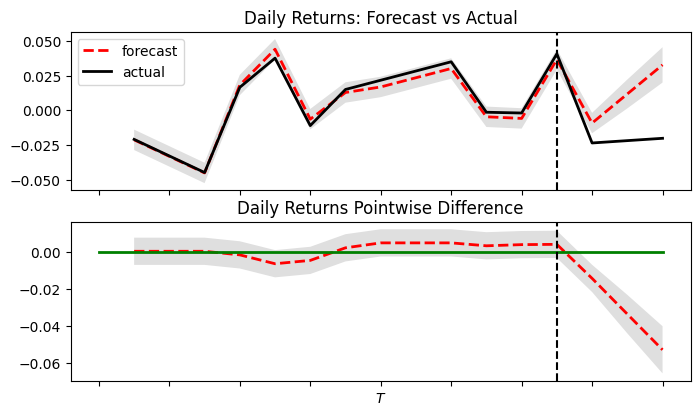

In [78]:
# !rm -r ../plots/bsts/twtr_*

twtr_plot_tweet_ids_causality = {
    "1515403974802870279": 0.04,
    "1286697906536361987": 0.989
}

for tweet_id, causality in twtr_plot_tweet_ids_causality.items():
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")
    print(f"causality: {causality  * 100}%")
    models[tweet_id].plot(fname=f"../plots/bsts/twtr_{tweet_id}.png")

#### Dogecoin

In [9]:
doge_tweet_ids = [
    # positive
    "1361094185412100096", 
    "1503222294277197829",
    "1395438318095986693",
    "1595591868275826688",
    "1113009339743100929",
    
    # negative
    "1517681356125392897",
    "1223754759921897472",
    
    # neutral
    "1392974251011895300",
    "1357241340313141249",
    "1538406040374595585",
    "1481873421390680065"
]

for tweet_id in doge_tweet_ids:
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")

[ID:1361094185412100096] If major Dogecoin holders sell most of their coins, it will get my full support. Too much concentration is the only real issue imo.
[ID:1503222294277197829] @saylor As a general principle, for those looking for advice from this thread, it is generally better to own physical things like a home or stock in companies you think make good products, than dollars when inflation is high.

I still own &amp; won’t sell my Bitcoin, Ethereum or Doge fwiw.
[ID:1395438318095986693] @heydave7 Yeah, I haven’t &amp; won’t sell any Doge
[ID:1595591868275826688] @teddyschleifer If SBF was as good at running a crypto exchange as he was at bribing media, FTX would still be solvent!
[ID:1113009339743100929] @Tom_Heats Dogecoin might be my fav cryptocurrency. It’s pretty cool.
[ID:1517681356125392897] @BillyM2k @engineers_feed So many “verified” scam crypto bots!
[ID:1223754759921897472] @nichegamer The crypto scam level on Twitter is reaching new levels. This is not cool.
[ID:139297

In [12]:
models = {}
for tweet_id in doge_tweet_ids:
    tweet = extract_tweet(selected_tweets_dict, tweet_id)
    excess_rets = bsts_prepare_data(assets["doge"], ff6_df)
    model = asset_tweet_pair_analysis(excess_rets, tweet)
    if model is not None:
        models[tweet_id] = model
    else:
        print(f"No data available around tweet date {tweet.date.values[0]} for tweet ID={tweet_id}")
    
print("\n##################################################################")
for tweet_id, model in models.items():
    print(f"TWEET ID: {tweet_id}")
    model.summary()
    print("\n##################################################################")


##################################################################
TWEET ID: 1361094185412100096
                                 Average        Cumulative
Actual                                 0                 0
Predicted                              0                 0
95% CI                            [0, 0]            [0, 0]
                                                          
Absolute Effect                        0                 0
95% CI                            [0, 0]            [0, 0]
                                                          
Relative Effect                  -222.3%           -222.3%
95% CI                  [59.9%, -504.4%]  [59.9%, -504.4%]
                                                          
P-value                            24.4%                  
Prob. of Causal Effect             75.6%                  
None

##################################################################
TWEET ID: 1503222294277197829
                                

[ID:1361094185412100096] If major Dogecoin holders sell most of their coins, it will get my full support. Too much concentration is the only real issue imo.
causality: 75.6%


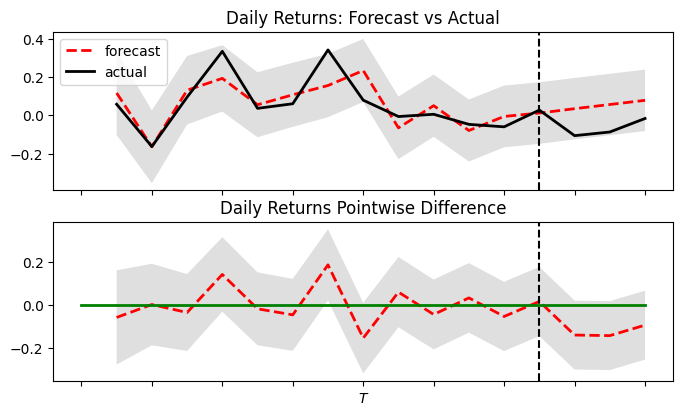

[ID:1223754759921897472] @nichegamer The crypto scam level on Twitter is reaching new levels. This is not cool.
causality: 94.89999999999999%


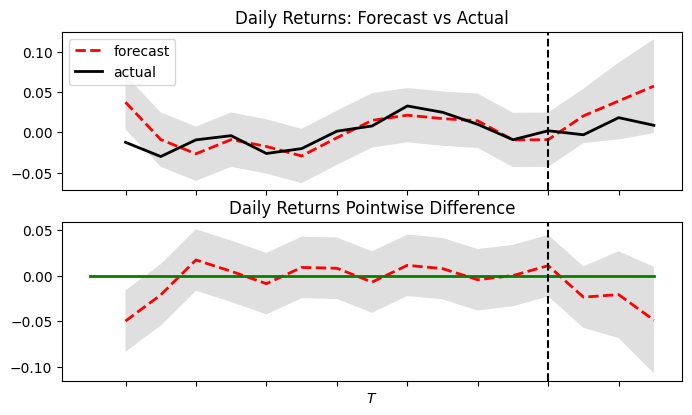

[ID:1392974251011895300] Working with Doge devs to improve system transaction efficiency. Potentially promising.
causality: 98.0%


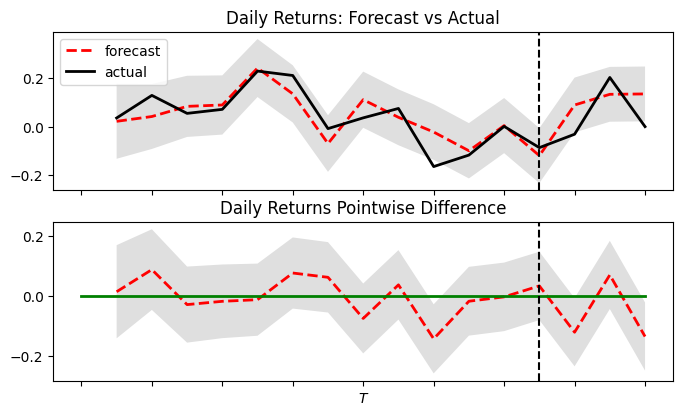

[ID:1357241340313141249] Dogecoin is the people’s crypto
causality: 83.6%


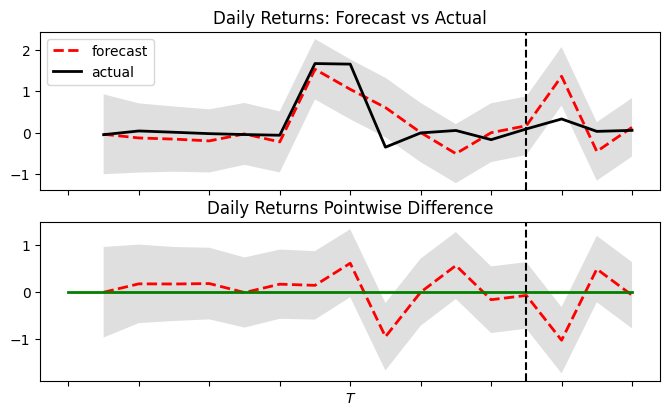

[ID:1538406040374595585] I will keep supporting Dogecoin
causality: 9.2%


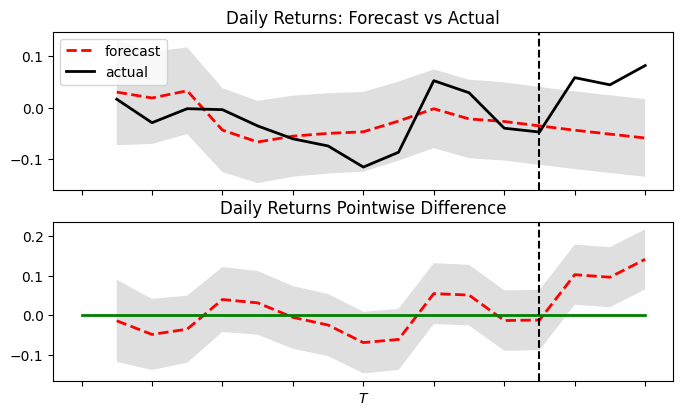

[ID:1481873421390680065] Tesla merch buyable with Dogecoin
causality: 100%


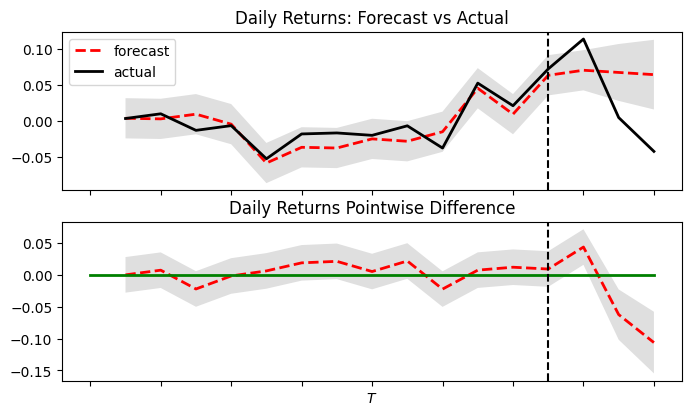

In [14]:
# !rm -r ../plots/bsts/doge_*

doge_plot_tweet_ids_causality = {
    "1361094185412100096": 0.756,
    "1223754759921897472": 0.949,
    "1392974251011895300": 0.98,
    "1357241340313141249": 0.836,
    "1538406040374595585": 0.092,
    "1481873421390680065": 1
    
}

for tweet_id, causality in doge_plot_tweet_ids_causality.items():
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")
    print(f"causality: {causality  * 100}%")
    models[tweet_id].plot(fname=f"../plots/bsts/doge_{tweet_id}.png")

#### Bitcoin

In [84]:
btc_tweet_ids = [
    # positive
    "1503222294277197829",
    "1595591868275826688",
    "1363021091086561285",
    "1261416824459030529",
    
    # negative
    "1517681356125392897",
    "1340588909974200321",
    "1223754759921897472",
    
    # neutral
    "1374617643446063105"
]

In [85]:
models = {}
for tweet_id in btc_tweet_ids:
    tweet = extract_tweet(selected_tweets_dict, tweet_id)
    excess_rets = bsts_prepare_data(assets["btc"], ff6_df)
    model = asset_tweet_pair_analysis(excess_rets, tweet)
    if model is not None:
        models[tweet_id] = model
    else:
        print(f"No data available around tweet date {tweet.date.values[0]} for tweet ID={tweet_id}")
    
print("\n##################################################################")
for tweet_id, model in models.items():
    print(f"TWEET ID: {tweet_id}")
    model.summary()
    print("\n##################################################################")


##################################################################
TWEET ID: 1503222294277197829
                                  Average         Cumulative
Actual                                  0                  0
Predicted                               0                  0
95% CI                             [0, 0]             [0, 0]
                                                            
Absolute Effect                         0                  0
95% CI                             [0, 0]             [0, 0]
                                                            
Relative Effect                    -30.0%             -30.0%
95% CI                  [181.9%, -241.9%]  [181.9%, -241.9%]
                                                            
P-value                             17.7%                   
Prob. of Causal Effect              82.3%                   
None

##################################################################
TWEET ID: 1595591868275826688
      

[ID:1503222294277197829] @saylor As a general principle, for those looking for advice from this thread, it is generally better to own physical things like a home or stock in companies you think make good products, than dollars when inflation is high.

I still own &amp; won’t sell my Bitcoin, Ethereum or Doge fwiw.
causality: 82.3%


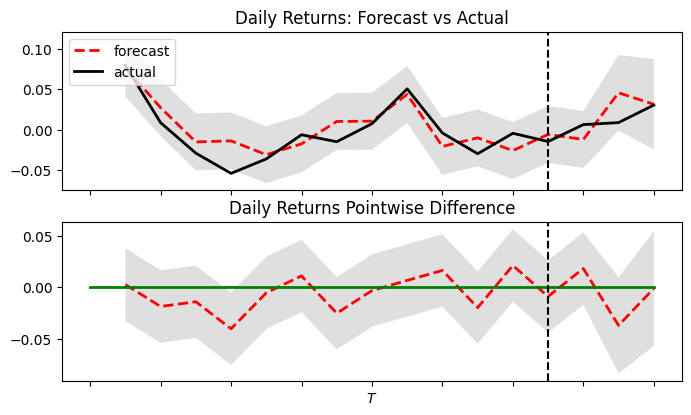

[ID:1261416824459030529] @jk_rowling Pretty much, although massive currency issuance by govt central banks is making Bitcoin Internet 👻 money look solid by comparison
causality: 98.9%


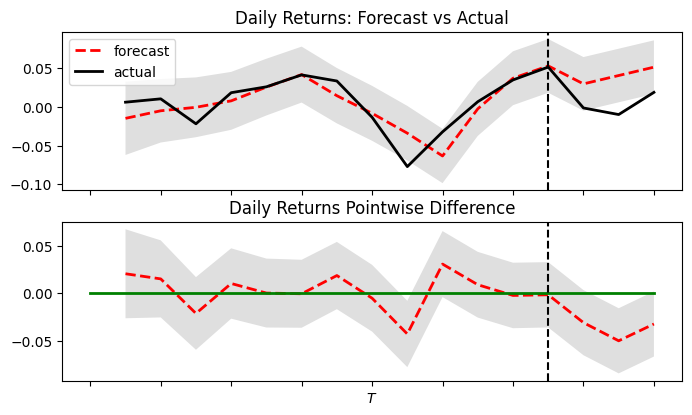

[ID:1340588909974200321] Bitcoin is almost as bs as fiat money
causality: 80.5%


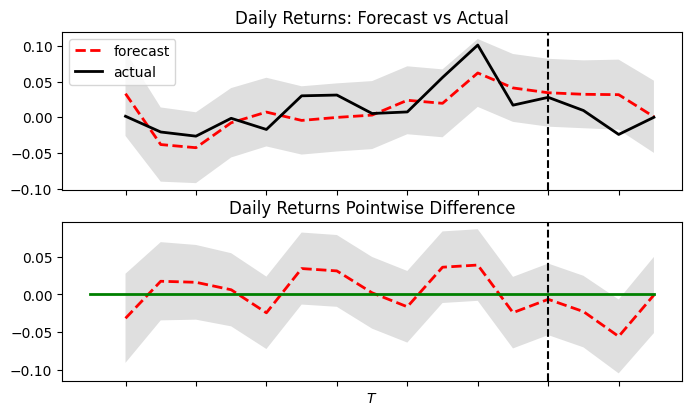

[ID:1223754759921897472] @nichegamer The crypto scam level on Twitter is reaching new levels. This is not cool.
causality: 99.9%


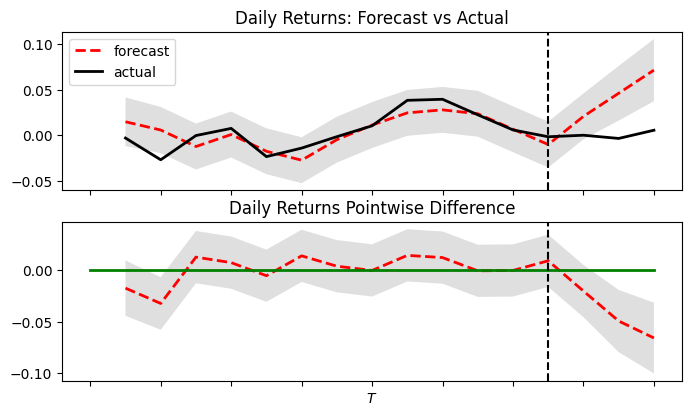

[ID:1374617643446063105] You can now buy a Tesla with Bitcoin
causality: 77.8%


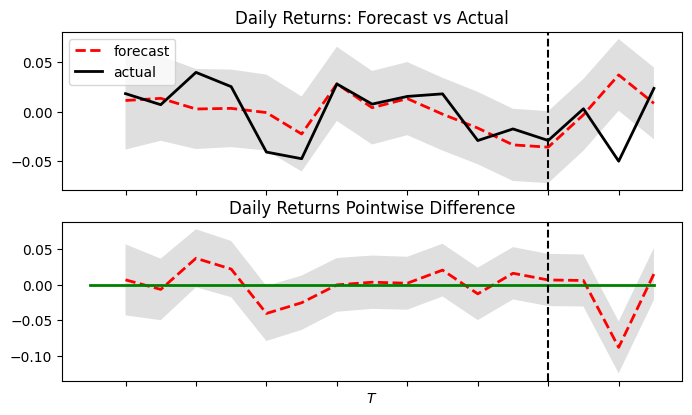

In [86]:
# !rm -r ../plots/bsts/btc_*

btc_plot_tweet_ids_causality = {
    "1503222294277197829": 0.823,
    "1261416824459030529": 0.989,
    "1340588909974200321": 0.805,
    "1223754759921897472": 0.999,
    "1374617643446063105": 0.778
}

for tweet_id, causality in btc_plot_tweet_ids_causality.items():
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")
    print(f"causality: {causality  * 100}%")
    models[tweet_id].plot(fname=f"../plots/bsts/btc_{tweet_id}.png")

#### Etherium

In [87]:
eth_tweet_ids = [
    # positive
    "1503222294277197829",
    "1595591868275826688",
    "1363021091086561285",
    
    # negative
    "1517681356125392897",
    "1223754759921897472"
]

In [88]:
models = {}
for tweet_id in eth_tweet_ids:
    tweet = extract_tweet(selected_tweets_dict, tweet_id)
    excess_rets = bsts_prepare_data(assets["eth"], ff6_df)
    model = asset_tweet_pair_analysis(excess_rets, tweet)
    if model is not None:
        models[tweet_id] = model
    else:
        print(f"No data available around tweet date {tweet.date.values[0]} for tweet ID={tweet_id}")
    
print("\n##################################################################")
for tweet_id, model in models.items():
    print(f"TWEET ID: {tweet_id}")
    model.summary()
    print("\n##################################################################")


##################################################################
TWEET ID: 1503222294277197829
                                     Average            Cumulative
Actual                                     0                     0
Predicted                                  0                     0
95% CI                                [0, 0]                [0, 0]
                                                                  
Absolute Effect                            0                     0
95% CI                                [0, 0]                [0, 0]
                                                                  
Relative Effect                      5660.4%               5660.4%
95% CI                  [18856.5%, -7535.7%]  [18856.5%, -7535.7%]
                                                                  
P-value                                49.4%                      
Prob. of Causal Effect                 50.6%                      
None

#########################

[ID:1363021091086561285] @PeterSchiff That said, BTC &amp; ETH do seem high lol
causality: 99.7%


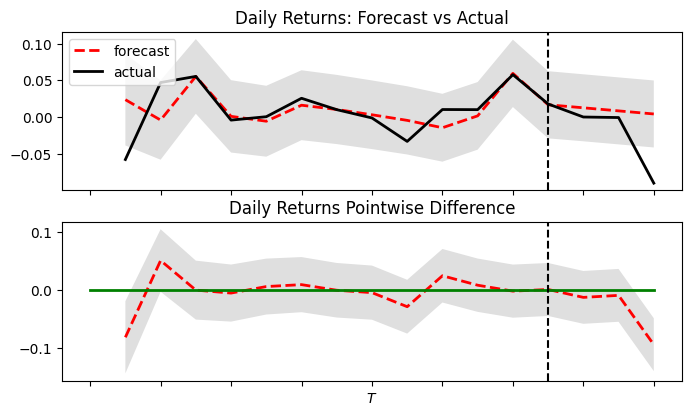

In [89]:
# !rm -r ../plots/bsts/eth_*

eth_plot_tweet_ids_causality = {
    "1363021091086561285": 0.997
}

for tweet_id, causality in eth_plot_tweet_ids_causality.items():
    text = extract_tweet(selected_tweets_dict, tweet_id).text.values[0]
    print(f"[ID:{tweet_id}] {text}")
    print(f"causality: {causality  * 100}%")
    models[tweet_id].plot(fname=f"../plots/bsts/eth_{tweet_id}.png")